### Setup: Import Dependencies
Run the cell below to import the relevant dependencies.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import functools

### Part 1: CMA-ES
Implement CMA-ES below.

In [42]:
def cmaes(fn, dim, num_iter=10):
  """Optimizes a given function using CMA-ES.

  Args:
    fn: A function that takes as input a vector and outputs a scalar value.
    dim: (int) The dimension of the vector that fn expects as input.
    num_iter: (int) Number of iterations to run CMA-ES.

  Returns:
    mu_vec: An array of size [num_iter, dim] storing the value of mu at each
      iteration.
    best_sample_vec: A list of length [num_iter] storing the function value
      for the best sample from each iteration of CMA-ES.
    mean_sample_vec: A list of length [num_iter] storing the average function
      value across samples from each iteration of CMA-ES.
  """
  # Hyperparameters
  sigma = 10
  population_size = 100
  p_keep = 0.10  # Fraction of population to keep
  noise = 0.25  # Noise added to covariance to prevent it from going to 0.

  # Initialize the mean and covariance
  mu = np.zeros(dim)
  cov = sigma**2 * np.eye(dim)

  mu_vec = []
  best_sample_vec = []
  mean_sample_vec = []
  for t in range(num_iter):
    # sample
    samples = np.random.multivariate_normal(mu, cov, population_size)

    # select elites
    evals = np.array([fn(s) for s in samples])
    idx = np.argsort(evals)[::-1][:int(p_keep * population_size)]
    elites = samples[idx]

    # update mean
    mu = np.mean(elites, axis=0)
    mu_vec.append(mu)

    # update covariance
    cov = np.cov(elites.T) + noise * np.eye(dim)

    best_sample_vec.append(np.max(evals))
    mean_sample_vec.append(np.mean(evals))

  return mu_vec, best_sample_vec, mean_sample_vec

In the cell below, we've defined a simply function:
$$f(x) = -\|x - x^*\|_2^2 \quad \text{where} \quad x^* = [65, 49].$$
This function is optimized when $x = x^*$. Run your implementation of CMA-ES on this function, confirming that you get the correct solution.

In [43]:
def test_fn(x):
  goal = np.array([65, 49])
  return -np.sum((x - goal)**2)

mu_vec, best_sample_vec, mean_sample_vec = cmaes(test_fn, dim=2, num_iter=100)

Run the following cell to visualize CMA-ES.

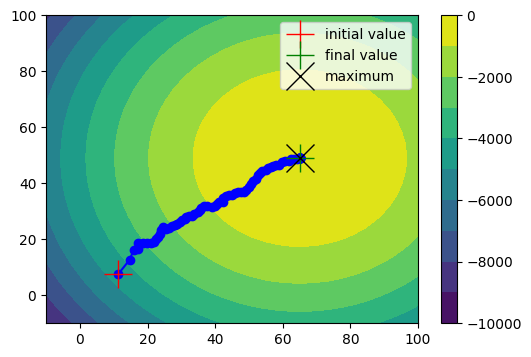

In [44]:
x = np.stack(np.meshgrid(np.linspace(-10, 100, 30), np.linspace(-10, 100, 30)), axis=-1)
fn_value = [test_fn(xx) for xx in x.reshape((-1, 2))]
fn_value = np.array(fn_value).reshape((30, 30))
plt.figure(figsize=(6, 4))
plt.contourf(x[:, :, 0], x[:, :, 1], fn_value, levels=10)
plt.colorbar()
mu_vec = np.array(mu_vec)
plt.plot(mu_vec[:, 0], mu_vec[:, 1], 'b-o')
plt.plot([mu_vec[0, 0]], [mu_vec[0, 1]], 'r+', ms=20, label='initial value')
plt.plot([mu_vec[-1, 0]], [mu_vec[-1, 1]], 'g+', ms=20, label='final value')
plt.plot([65], [49], 'kx', ms=20, label='maximum')
plt.legend()
plt.show()

Next, you will apply CMA-ES to a more complicating: maximizing the expected reward of a RL agent. The policy takes action LEFT with probability:
$$\pi(a = \text{LEFT} \mid s) = s \cdot w + b,$$
where $w \in \mathbb{R}^4$ and $b \in \mathbb{R}$ are parameters that you will optimize with CMA-ES. In the cell below, define a function that takes as input a single vector $x = (w, b)$ and the environment and returns the total (undiscounted) reward from one episode.

In [45]:
def _sigmoid(x):
  return 1 / (1 + np.exp(-x))

def _get_action(s, params):
  w = params[:4]
  b = params[4]
  p_left = _sigmoid(w @ s + b)
  a = np.random.choice(2, p=[p_left, 1 - p_left])
  return a

def rl_fn(params, env):
  assert len(params) == 5
  
  # run for one episode 
  total_rewards = 0
  s = env.reset()[0]
  done = False
  truncated = False
  while not done and not truncated:
    a = _get_action(s, params)
    s, r, done, truncated, _ = env.step(a)
    total_rewards += r

  return total_rewards

In [46]:
for param in [(-1, -1, -1, -1, -1), (1,0,1,0,1), (0,1,2,3,4)]:
    ret = 0
    env = gym.make('CartPole-v0')
    for i in range(10000):
        ret += rl_fn(param, env)
    print(param, ret / 10000)

/Users/zhichen3/opt/anaconda3/envs/DRLhw2/lib/python3.7/site-packages/gym/envs/registration.py:556: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "


(-1, -1, -1, -1, -1) 15.6954
(1, 0, 1, 0, 1) 14.3238
(0, 1, 2, 3, 4) 9.4371


The cell below applies your CMA-ES implementation to the RL objective you've defined in the cell above.

In [47]:
env = gym.make('CartPole-v0')
fn_with_env = functools.partial(rl_fn, env=env)
mu_vec, best_sample_vec, mean_sample_vec = cmaes(fn_with_env, dim=5, num_iter=10)

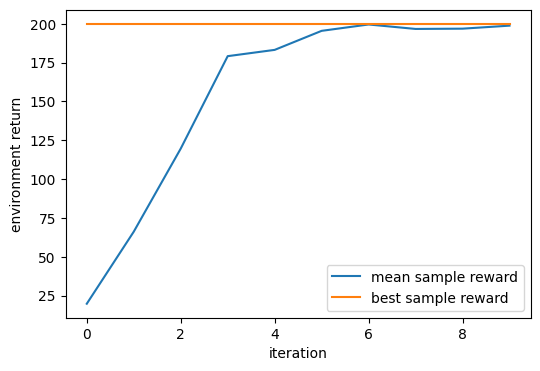

In [51]:
plt.figure(figsize=(6, 4))
plt.plot(mean_sample_vec, label='mean sample reward')
plt.plot(best_sample_vec, label='best sample reward')
plt.xlabel('iteration')
plt.ylabel('environment return')
plt.legend()
plt.show()